### Install libraries

In [ ]:
!pip install -U datasets[audio]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
! pip install torchaudio

In [ ]:
!pip install torchcodec

## Imports

In [ ]:
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd

In [ ]:
import torchcodec

In [ ]:
from datasets import load_dataset, Audio

In [ ]:
SR = 32000 # SAMPLE RATE

In [ ]:
ds = load_dataset("zahidpichen/violine_dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/120 [00:00<?, ?B/s]

violine_dataset/train/audio_1.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/train/audio_2.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/train/audio_3.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/train/audio_4.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/test/audio_5.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/test/audio_6.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2 [00:00<?, ? examples/s]

In [ ]:
sample = ds['train'][0]['audio']

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import librosa # Added librosa import for frames_to_time

def plot_spect(spectrogram,mode='mel'):
  """
  Mode options:
    - 'linear', 'fft', 'hz': Displays frequencies on a linear scale, determined by the FFT window and sampling rate.
    - 'log': Displays frequencies on a logarithmic scale.
    - 'mel': Displays frequencies on the Mel scale, often used for representing human perception of pitch.
    - 'cqt_hz': Displays frequencies based on the Constant-Q Transform (CQT) in Hz.
    - 'cqt_note': Displays pitches based on the CQT, labeled with musical note names (e.g., C1, G#2)
  """
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram, sr=SR, x_axis='time', y_axis=mode)
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'{mode.capitalize()} Spectrogram')
  plt.tight_layout()
  plt.show()

def plot_signal(signal):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=SR)
  plt.title('Audio Waveform')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.tight_layout()
  plt.show()

def plot_signal_with_onsets(signal, onsets_frames, sr, hop_length=512):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=sr)
  plt.title('Audio Waveform with Onsets')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')

  # Convert onset frames to time
  onset_times = librosa.frames_to_time(onsets_frames, sr=sr, hop_length=hop_length)

  # Plot vertical lines at onset times
  for time in onset_times:
    plt.axvline(x=time, color='r', linestyle='--', alpha=0.8)

  plt.tight_layout()
  plt.show()

# Onset Detection

In [ ]:
signal = sample['array']

In [ ]:
HOP = SR // 2

In [ ]:
signal

array([0.        , 0.        , 0.        , ..., 0.08539715, 0.07609099,
       0.05157228], dtype=float32)

In [ ]:
onset = librosa.onset.onset_detect(y=signal,
                           sr=SR,
                           hop_length=512,
                           units='frames',
                           normalize=True, # Key for having good results
                           sparse=True)

In [ ]:
onset

array([ 243,  248,  445,  464,  484,  501,  520,  536,  547,  558,  573,
        695,  788,  795,  805,  822,  838,  856,  888,  895,  907,  912,
        990, 1000, 1008, 1025, 1042, 1067, 1080, 1096, 1138, 1174, 1343,
       1350, 1365, 1383, 1464, 1511, 1543, 1589, 1629, 1674, 1804, 1859])

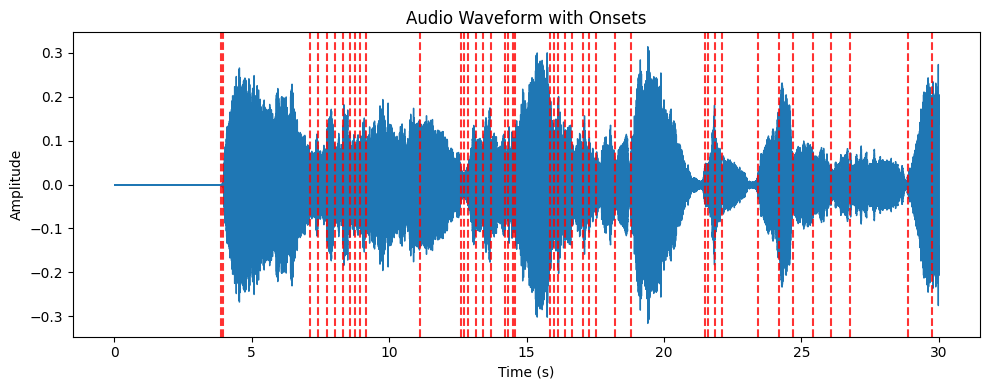

In [ ]:
plot_signal_with_onsets(signal, onset, SR, hop_length=512)

## Filtering results

In [ ]:
if len(onset) > 0:
    filtering = [onset[0]] # Always keep the first onset
    for i in range(1, len(onset)):
        # If the current onset is at least 'threshold' frames away from the last accepted onset
        if onset[i] - filtering[-1] >= threshold:
            filtering.append(onset[i])
    filtered_onset = np.array(filtering) # Update the 'onset' variable
else:
    onset = np.array([]) # If original onset was empty, filtered_onsets is also empty

In [ ]:
filtered_onset

array([ 243,  445,  501,  558,  695,  788,  838,  888,  990, 1042, 1096,
       1174, 1343, 1464, 1543, 1629, 1804, 1859])

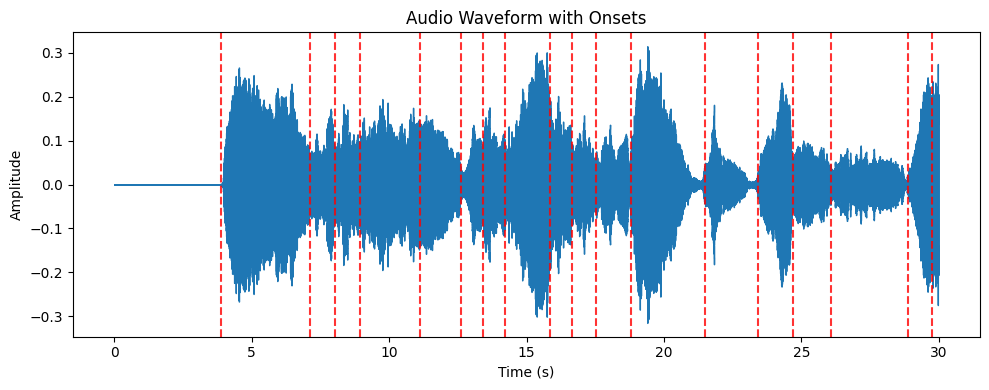

In [ ]:
plot_signal_with_onsets(signal, filtered_onset, SR, hop_length=512)

In [ ]:
ipd.Audio(sample['array'], rate=SR)

---
# Video visualization

## Plots to Arrays

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported for np.array

def fig_to_numpy(func):
    """
    Decorator that converts the Matplotlib Figure returned by a function
    into a NumPy array (H, W, 4 - RGBA) and closes the figure.
    It now accepts a 'show' keyword argument in the decorated function call
    to optionally display the plot before returning the numpy array.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Pop 'show' from kwargs, defaulting to False if not present
        should_show_plot = kwargs.pop('show', True)

        # 1. Call the original function to get the Figure object
        fig, ax = func(*args, **kwargs) # Pass remaining kwargs to the original function

        # 2. Conversion Logic
        if fig is None:
            return None

        fig.canvas.draw()
        img_array = np.array(fig.canvas.renderer.buffer_rgba())

        # 3. Get the data limits of the x-axis
        x_data_min, x_data_max = ax.get_xlim()

        # Convert these data limits to pixel coordinates
        # The transform method expects a (x, y) tuple or an array of (x,y) points
        # We provide an arbitrary y-value (like 0) since we only care about the x-pixel position for the x-axis start/end
        x_start, _ = np.int16(ax.transData.transform((x_data_min, 0))) # Pixel coordinate for x_data_min
        x_end, _ = np.int16(ax.transData.transform((x_data_max, 0)))   # Pixel coordinate for x_data_max
        x_axis = (x_start, x_end)

        # 4. Optionally show the plot *before* closing the figure
        if should_show_plot:
            plt.show()

        # 5. Memory Cleanup (Crucial!)
        plt.close(fig)

        # 6. Return the new output type (the NumPy array)
        return img_array, x_axis
    return wrapper

In [ ]:
@fig_to_numpy
def plot_spect(spectrogram,mode='mel'):
  """
  Mode options:
    - 'linear', 'fft', 'hz': Displays frequencies on a linear scale, determined by the FFT window and sampling rate.
    - 'log': Displays frequencies on a logarithmic scale.
    - 'mel': Displays frequencies on the Mel scale, often used for representing human perception of pitch.
    - 'cqt_hz': Displays frequencies based on the Constant-Q Transform (CQT) in Hz.
    - 'cqt_note': Displays pitches based on the CQT, labeled with musical note names (e.g., C1, G#2)
  """
  fig = plt.subplots(figsize=(10, 4))
  ax = fig.add_axes([0, 0, 1, 1])
  librosa.display.specshow(spectrogram, sr=SR, x_axis='time', y_axis=mode, ax=ax)
  plt.colorbar(format='%+2.0f dB')
  ax.set_title(f'{mode.capitalize()} Spectrogram')
  fig.tight_layout()
  return fig, ax

@fig_to_numpy
def plot_signal(signal):
  fig, ax = plt.subplots(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=SR, ax=ax)
  ax.margins(x=0)
  ax.set_title('Audio Waveform')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Amplitude')
  fig.tight_layout()
  return fig, ax

@fig_to_numpy
def plot_signal_with_onsets(signal, onsets_frames, sr, hop_length=512):
  fig, ax = plt.subplots(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=sr, ax=ax, alpha=0.5)
  ax.margins(x=0)
  ax.set_title('Audio Waveform with Onsets')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Amplitude')

  # Convert onset frames to time
  onset_times = librosa.frames_to_time(onsets_frames, sr=sr, hop_length=hop_length)

  # Plot vertical lines at onset times
  for time in onset_times:
    ax.axvline(x=time, color='r', linestyle='--', alpha=0.8)
  #ax.label_outer()
  fig.tight_layout()
  return fig, ax

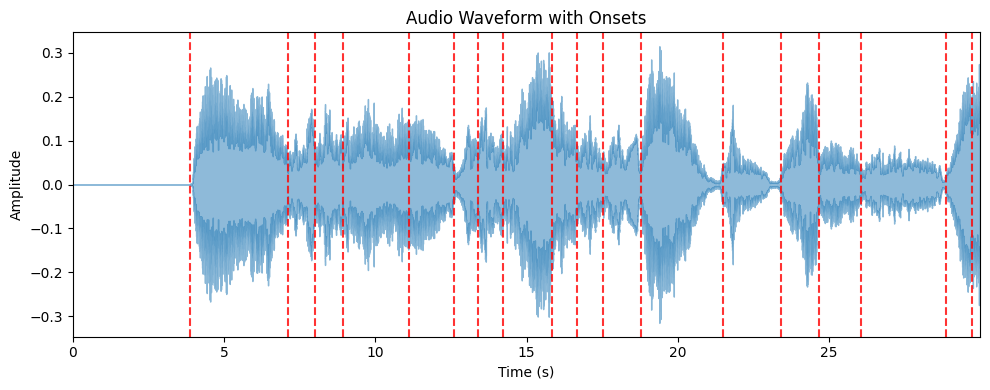

In [ ]:
array, t_axis = plot_signal_with_onsets(signal, filtered_onset, SR, hop_length=512)

## Time cursor (synced audio)

In [ ]:
t_axis

(np.int16(77), np.int16(985))

In [ ]:
@fig_to_numpy
def overlay_vertical_line(image_array, x, color='blue', linestyle='--', linewidth=1, scale=(0.5,0.5)):
    """
    Overlays a vertical line on an image at a specified x-coordinate.

    Args:
        image_array (np.ndarray): The input image as a NumPy array.
        x_coordinate (int): The x-coordinate (column index) where the vertical line should be drawn.
        color (str, optional): The color of the line (e.g., 'red', 'blue', 'gray'). Defaults to 'blue'.
        linestyle (str, optional): The style of the line (e.g., '-', '--', '-.', ':'). Defaults to '--'.
        linewidth (int, optional): The thickness of the line. Defaults to 1.
        scale (tuple, optional): A tuple (ymin, ymax) representing the proportion of the y-axis height the line should span (0 to 1). Defaults to (0.5, 0.5).
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    ax.margins(0)
    ax.imshow(image_array, interpolation='none') # Display the RGBA image array

    # Use the provided scale tuple directly for ymin_frac and ymax_frac
    ymin_frac = scale[0]
    ymax_frac = scale[1]

    ax.axvline(x=x, ymin=ymin_frac, ymax=ymax_frac, color=color, linestyle=linestyle, linewidth=linewidth, alpha=0.7)
    ax.axis('off')  # Turn off axis labels and ticks
    return fig, ax

In [ ]:
bar_scale = (0.15,0.9)

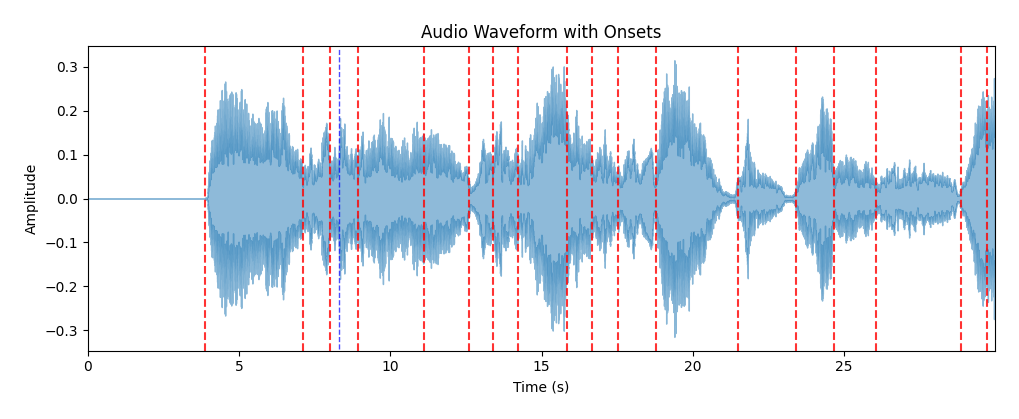

In [ ]:
img, _ = overlay_vertical_line(array,t_axis[1]//3, scale = bar_scale)

## Animation

In [ ]:
def animate_time_bar(image_array, x_axis):
    """
    Animates the overlay of vertical lines on an image.
    """
    animation = []
    for x in range(x_axis[0],x_axis[1]):
        frame, _ = overlay_vertical_line(image_array, x, scale=bar_scale, show=False)
        animation.append(frame)
    return animation


In [ ]:
animation = animate_time_bar(array,t_axis)

In [ ]:
n_frames = len(animation)
n_samples = len(signal)
samples_per_frame = n_samples // n_frames
samples_per_frame

1057

## Video generation

In [ ]:
!pip install moviepy

In [ ]:
import soundfile as sf
from moviepy.editor import AudioFileClip, ImageSequenceClip
import os

In [ ]:
# 1. Save the signal to a temporary WAV file
audio_filename = "temp_audio.wav"
sf.write(audio_filename, signal, SR)

# 2. Create an AudioFileClip from the temporary WAV file
audio_clip = AudioFileClip(audio_filename)

# 3. Extract image arrays from the animation list
# The 'animation' variable correctly contains (H, W, 4) numpy arrays
image_frames = animation # Directly use the list of image arrays

# 4. Create an ImageSequenceClip from the extracted image arrays
# Calculate the duration per frame to synchronize with the audio
duration_per_frame = audio_clip.duration / len(image_frames)
video_clip = ImageSequenceClip(image_frames, fps=1/duration_per_frame)

# 5. Set the audio of the video clip
final_clip = video_clip.set_audio(audio_clip)

# 6. Write the final video file
output_filename = "animated_audio.mp4"
final_clip.write_videofile(output_filename, codec='libx264', audio_codec='aac')

# Clean up the temporary audio file
os.remove(audio_filename)

print(f"Video saved as {output_filename}")

Moviepy - Building video animated_audio.mp4.
MoviePy - Writing audio in animated_audioTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video animated_audio.mp4



Moviepy - Done !
Moviepy - video ready animated_audio.mp4
Video saved as animated_audio.mp4


## Final result

In [ ]:
Video("animated_audio.mp4", embed=True, width=800, height=500)

## Summary:

### Data Analysis Key Findings
*   The `moviepy` library (version 1.0.3) and its dependencies were already satisfied, indicating it was pre-installed in the environment.
*   An initial attempt to create the video failed due to a `NameError` because `ImageSequenceClip` was missing from the import statement.
*   After correcting the import statement to include `ImageSequenceClip`, the `animated_audio.mp4` file was successfully generated with synchronized animation and audio.
*   The created video was successfully displayed within the notebook environment.

### Insights or Next Steps
*   The process successfully demonstrated how to generate a synchronized video from animation frames and audio data using the `moviepy` library.
*   For future video generation tasks, ensure all necessary components (e.g., `ImageSequenceClip` in this case) are explicitly imported from the `moviepy.editor` module to avoid runtime errors.
